In [1]:
import os
import glob
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm.auto import tqdm

# Read csv and extract meta info

In [2]:
df_train = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
df_train = df_train.sort_values(["id", "class"]).reset_index(drop = True)
df_train["patient"] = df_train.id.apply(lambda x: x.split("_")[0])
df_train["days"] = df_train.id.apply(lambda x: "_".join(x.split("_")[:2]))

all_image_files = sorted(glob.glob("../input/uw-madison-gi-tract-image-segmentation/train/*/*/scans/*.png"), key = lambda x: x.split("/")[5] + "_" + x.split("/")[7])
size_x = [int(os.path.basename(_)[:-4].split("_")[-4]) for _ in all_image_files]
size_y = [int(os.path.basename(_)[:-4].split("_")[-3]) for _ in all_image_files]
spacing_x = [float(os.path.basename(_)[:-4].split("_")[-2]) for _ in all_image_files]
spacing_y = [float(os.path.basename(_)[:-4].split("_")[-1]) for _ in all_image_files]
df_train["image_files"] = np.repeat(all_image_files, 3)
df_train["spacing_x"] = np.repeat(spacing_x, 3)
df_train["spacing_y"] = np.repeat(spacing_y, 3)
df_train["size_x"] = np.repeat(size_x, 3)
df_train["size_y"] = np.repeat(size_y, 3)
df_train["slice"] = np.repeat([int(os.path.basename(_)[:-4].split("_")[-5]) for _ in all_image_files], 3)
df_train

,id,class,segmentation,patient,days,image_files,spacing_x,spacing_y,size_x,size_y,slice
0,case101_day20_slice_0001,large_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,1
1,case101_day20_slice_0001,small_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,1
2,case101_day20_slice_0001,stomach,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,1
3,case101_day20_slice_0002,large_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,2
4,case101_day20_slice_0002,small_bowel,NaN,case101,case101_day20,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,266,266,2
...,...,...,...,...,...,...,...,...,...,...,...
115483,case9_day22_slice_0143,small_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,143
115484,case9_day22_slice_0143,stomach,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,143
115485,case9_day22_slice_0144,large_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,144
115486,case9_day22_slice_0144,small_bowel,NaN,case9,case9_day22,../input/uw-madison-gi-tract-image-segmentatio...,1.5,1.5,360,310,144


# Make mmseg-format data (2.5D by default)

In [3]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

!mkdir -p ../data/mmseg_train_25d_carno/{images_25d,images_1d,labels,splits}
for day, group in tqdm(df_train.groupby("days")):
    patient = group.patient.iloc[0]
    imgs = []
    msks = []
    file_names = []
    for file_name in group.image_files.unique():
        img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
        segms = group.loc[group.image_files == file_name]
        masks = {}
        for segm, label in zip(segms.segmentation, segms["class"]):
            if not pd.isna(segm):
                mask = rle_decode(segm, img.shape[:2])
                masks[label] = mask
            else:
                masks[label] = np.zeros(img.shape[:2], dtype = np.uint8)
        masks = np.stack([masks[k] for k in sorted(masks)], -1)
        imgs.append(img)
        msks.append(masks)
        
    imgs = np.stack(imgs, 0)
    msks = np.stack(msks, 0)
    for i in range(msks.shape[0]):
        img25d = imgs[[max(0, i - 2), i, min(imgs.shape[0] - 1, i + 2)]].transpose(1,2,0) # 2.5d data
        img1d = imgs[i]
        msk = msks[i]
        new_file_name = f"{day}_{i}.png"
        cv2.imwrite(f"../data/mmseg_train_25d_carno/images_25d/{new_file_name}", img25d)
        cv2.imwrite(f"../data/mmseg_train_25d_carno/images_1d/{new_file_name}", img1d)
        cv2.imwrite(f"../data/mmseg_train_25d_carno/labels/{new_file_name}", msk)

  0%|          | 0/274 [00:00<?, ?it/s]

# Make fold splits

In [4]:
all_image_files = glob.glob("../data/mmseg_train_25d_carno/images_1d/*")
patients = [os.path.basename(_).split("_")[0] for _ in all_image_files]


from sklearn.model_selection import GroupKFold

split = list(GroupKFold(5).split(patients, groups = patients))

for fold, (train_idx, valid_idx) in enumerate(split):
    with open(f"../data/mmseg_train_25d_carno/splits/fold_{fold}.txt", "w") as f:
        for idx in train_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")
    with open(f"../data/mmseg_train_25d_carno/splits/holdout_{fold}.txt", "w") as f:
        for idx in valid_idx:
            f.write(os.path.basename(all_image_files[idx])[:-4] + "\n")

# Check 2.5d data

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import numpy as np

In [2]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

case119_day21_5.png
(266, 266, 3)
[0]


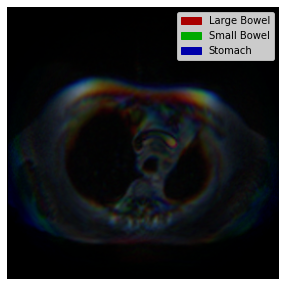

In [5]:
i=134
img_name_list = os.listdir('../data/mmseg_train_25d_carno/images_1d')
img_name = img_name_list[i]
print(img_name)
img = load_img(os.path.join('../data/mmseg_train_25d_carno/images_25d',img_name))
mask_path = os.path.join('../data/mmseg_train_25d_carno/labels', img_name)
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
print(mask.shape)
print(np.unique(mask))
plt.figure(figsize=(5,5))
mask[mask==1]=255
show_img(img, mask=mask)